# MSc Data Science: (deep) discriminative models for **MNIST**

# Loading useful stuff

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras import initializers

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

#Loading and normalising MNIST

In [2]:
(train_images, y_train), (test_images,  y_test) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28*28)
test_images = test_images.reshape(test_images.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int32)
y_test =tf.cast(y_test, tf.int32)

11501568/11490434 [==============================] - 0s 0us/step


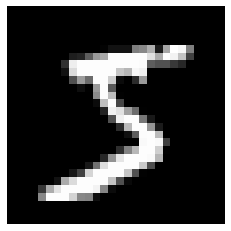

In [3]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

In [4]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images/255.
test_images = test_images/255.

# Logistic regression

Our goal is to build a classifier on MNIST. A first simple example of classifier is **logistic regression**, a particular case of **discriminative model**. The model for (multiclass) logistic regression is 
$$ p (y | \mathbf{x} ) = \text{Cat} (y |\text{Softmax}(\mathbf{W}\mathbf{x}+\mathbf{b})),$$
where the unknown parameters are $\mathbf{W}$ and $\mathbf{b}$.

**Question 1.** What are the dimensions of $\mathbf{W}$ and $\mathbf{b}$? What is the total number of parameters in the model?

$$W\in\mathbb{R}^{10\times784}$$
$$b\in\mathbb{R}^{10}$$

In [6]:
train_images[0].shape

(784,)

We will build our logistic regression model using [**keras**](https://keras.io/), a nice deep learning API. In particular, keras's [sequential model](https://keras.io/guides/sequential_model/) is simple way of building compositions of parametric functions.

In [7]:
logistic_regression = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(10, kernel_initializer=initializers.RandomNormal(stddev=1)) # because we have 10 classes
])

Here, $\texttt{logistic_regression}$ represents the function $ \mathbf{x} \mapsto \mathbf{W}\mathbf{x}+\mathbf{b}$, that takes vectors as inputs, and returns probabilities for each class. We can try with the first MNIST image. The model is initialised by sampling each coefficient of $\mathbf{W}$ from a standard Gaussian distribution.

In [8]:
logistic_regression(train_images[0:1,])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 14.398406  ,   9.759026  ,   7.282996  ,   6.4654703 ,
        -14.880961  ,   3.152071  ,  -4.856968  ,   4.6309824 ,
          0.36624956,   9.990465  ]], dtype=float32)>

Note that the output is a Tensorflow tensor. One can easily get a Numpy array instead this way:

In [9]:
logistic_regression(train_images[0:1,]).numpy()

array([[ 14.398406  ,   9.759026  ,   7.282996  ,   6.4654703 ,
        -14.880961  ,   3.152071  ,  -4.856968  ,   4.6309824 ,
          0.36624956,   9.990465  ]], dtype=float32)

This $\texttt{logistic_regression}$ conveniently can also handle **batches** of inputs. Here we look at the predictions of the 10 first digits of MNIST.

In [10]:
tf.nn.softmax(logistic_regression(train_images[0:10,]).numpy())

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[9.7743452e-01, 9.4455909e-03, 7.9415645e-04, 3.5063879e-04,
        1.8802726e-13, 1.2760463e-05, 4.2421360e-09, 5.5995031e-05,
        7.8704608e-07, 1.1905461e-02],
       [2.1088786e-01, 7.8894293e-01, 9.7266957e-07, 7.2862369e-09,
        2.2465319e-07, 6.8607675e-10, 3.5139720e-16, 1.3819966e-08,
        2.0155348e-16, 1.6794112e-04],
       [8.0089545e-04, 1.3203209e-08, 9.5567942e-01, 3.8552933e-10,
        6.1706291e-04, 1.4933558e-04, 4.1724567e-04, 1.3743354e-06,
        1.5852065e-09, 4.2334657e-02],
       [8.2788712e-05, 1.5258001e-01, 1.7019792e-07, 8.1430542e-01,
        1.2785073e-07, 6.7236812e-07, 1.8456838e-06, 5.5242361e-10,
        3.3028960e-02, 2.7414859e-09],
       [6.4391261e-01, 3.5545176e-01, 7.6010975e-11, 2.5693338e-05,
        7.6150404e-06, 2.4467399e-09, 9.7722821e-14, 1.0665828e-11,
        2.1802928e-09, 6.0232927e-04],
       [7.0909003e-12, 9.9995232e-01, 6.7542173e-20, 3.9691757e-05,
       

One can check that each row of these predictions sums to one:

In [11]:
np.sum(tf.nn.softmax(logistic_regression(train_images[0:10,]), axis=1).numpy(),1)

array([0.9999999 , 0.99999994, 1.        , 1.        , 1.        ,
       0.99999994, 1.0000001 , 1.        , 1.        , 1.        ],
      dtype=float32)

One can us Tensorflow Probability to create the distribution  $p (y | \mathbf{x} )$

In [12]:
p_ygivenx_logistic_regression = tfd.Categorical(logits = logistic_regression(train_images[0:10,]))

In [13]:
p_ygivenx_logistic_regression.sample() # sampling the predicted labels

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 0, 1, 0, 9, 0, 4], dtype=int32)>

In [14]:
p_ygivenx_logistic_regression.mode() # looking at the most probable labels

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 0, 1, 0, 9, 0, 4], dtype=int32)>

# Training the logistic regression model

To train the classifier, we define a function that performs a gradient descent step. First, we choose the flavour of SGD that we want (in this case, the [fairly famous Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)).

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [16]:
@tf.function
def train_step_logistic_regression(data, labels):
  # step 1: explain how to compute gradients
  with tf.GradientTape() as tape: 
    # the gradient tape saves all the step that needs to be saved for automatic differentiation
    # One could also use logits rather than probs and remove the softmax layer...
    p_ygivenx_logistic_regression = tfd.Categorical(logits = logistic_regression(data))
    # compute log(p(labels|data))
    logp_ygivenx_logistic_regression = p_ygivenx_logistic_regression.log_prob(labels)
    # the loss is the average negative log likelihood
    loss = -tf.reduce_mean(logp_ygivenx_logistic_regression) 
  #step 2: computation of gradients
  gradients = tape.gradient(loss, logistic_regression.trainable_variables)  # here, the gradient is automatically computed
  # step 3: do one iteration of optimizer
  optimizer.apply_gradients(zip(gradients, logistic_regression.trainable_variables))  # Adam iteration

In [17]:
@tf.function
def evaluate_logistic_regression(data, labels):
  p_ygivenx_logistic_regression = tfd.Categorical(logits = logistic_regression(data))
  logp_ygivenx_logistic_regression = p_ygivenx_logistic_regression.log_prob(labels)
  log_likelihood = tf.reduce_mean(logp_ygivenx_logistic_regression)
  y_pred = p_ygivenx_logistic_regression.mode()
  acc = tf.reduce_mean(tf.cast(y_pred == labels,tf.float32))
  return acc, log_likelihood

In [18]:
 evaluate_logistic_regression(train_images,y_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.096883334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-14.342852>)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,y_train)).shuffle(60000).batch(32) # TF creates the batches for us

In [23]:
EPOCHS = 50

for epoch in range(1,EPOCHS+1):
  for images, labels in train_dataset:
    train_step_logistic_regression(images, labels) # Adam iteration
  acc, log_likelihood = evaluate_logistic_regression(train_images,y_train)
  acc_test, log_likelihood_test = evaluate_logistic_regression(test_images,y_test)
  print('Epoch  %g' %epoch)
  print('Train accuracy  %g' %acc.numpy())
  print('Test accuracy  %g' %acc_test.numpy())
  print('Train log-likelihood  %g' %log_likelihood.numpy())
  print('Test log-likelihood  %g' %log_likelihood_test.numpy())
  print('-----------')

Epoch  1
Train accuracy  0.693783
Test accuracy  0.7007
Train log-likelihood  -1.63976
Test log-likelihood  -1.57222
-----------
Epoch  2
Train accuracy  0.712617
Test accuracy  0.7197
Train log-likelihood  -1.52026
Test log-likelihood  -1.45722
-----------
Epoch  3
Train accuracy  0.728783
Test accuracy  0.7343
Train log-likelihood  -1.42138
Test log-likelihood  -1.36277
-----------
Epoch  4
Train accuracy  0.7421
Test accuracy  0.7477
Train log-likelihood  -1.33791
Test log-likelihood  -1.28341
-----------
Epoch  5
Train accuracy  0.753683
Test accuracy  0.7588
Train log-likelihood  -1.26654
Test log-likelihood  -1.21599
-----------
Epoch  6
Train accuracy  0.763417
Test accuracy  0.7688
Train log-likelihood  -1.20525
Test log-likelihood  -1.15848
-----------
Epoch  7
Train accuracy  0.772483
Test accuracy  0.7778
Train log-likelihood  -1.15181
Test log-likelihood  -1.10903
-----------
Epoch  8
Train accuracy  0.780133
Test accuracy  0.784
Train log-likelihood  -1.10524
Test log-like

In [24]:
print(logistic_regression(train_images[0:1,]), y_train[0], "", sep="\n")
evaluate_logistic_regression(train_images[0:1,:],y_train[0])

tf.Tensor(
[[  3.8855178  -9.357399    2.5331233  12.701228  -15.107371   13.599654
   -0.6550052   6.639809    3.9878988   0.5572613]], shape=(1, 10), dtype=float32)
tf.Tensor(5, shape=(), dtype=int32)



(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.34238696>)

## Alternative way of defining and training the model

We can actually put the distribution inside the kera sequential model:

In [68]:
logistic_regression = tfk.Sequential(
    [tfkl.InputLayer(input_shape=[28*28,]),
     tfkl.Dense(10, kernel_initializer=initializers.RandomNormal(stddev=1)),
     #tpf.layers. <- instead of tfpl
     tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.Categorical(logits = t), 
                             convert_to_tensor_fn=lambda s: s.mode())
     ]
)

We now need to define a loss function than can handle probabilistic predictions:

In [69]:
logistic_regression(train_images[:10,:]).sample(2)

<tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[2, 1, 6, 2, 6, 2, 0, 2, 6, 2],
       [2, 1, 6, 2, 6, 2, 0, 2, 4, 2]], dtype=int32)>

In [70]:
logistic_regression(train_images[:10,:]).mode()

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([2, 1, 6, 2, 6, 2, 0, 2, 6, 2], dtype=int32)>

In [71]:
neg_loglikelihood = lambda y, pred: -pred.log_prob(y)

We now need to compile our model.

In [72]:
logistic_regression.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005), 
                            loss = neg_loglikelihood,
                            metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [73]:
logistic_regression.fit(train_images, y_train, validation_data=(test_images, y_test), verbose=2, epochs=20)

Epoch 1/20
1875/1875 - 4s - loss: 8.0858 - categorical_accuracy: 0.0907 - val_loss: 6.1329 - val_categorical_accuracy: 0.0895
Epoch 2/20
1875/1875 - 3s - loss: 5.3605 - categorical_accuracy: 0.0779 - val_loss: 4.7647 - val_categorical_accuracy: 0.0607
Epoch 3/20
1875/1875 - 3s - loss: 4.3977 - categorical_accuracy: 0.0517 - val_loss: 4.0814 - val_categorical_accuracy: 0.0639
Epoch 4/20
1875/1875 - 3s - loss: 3.8886 - categorical_accuracy: 0.0747 - val_loss: 3.7035 - val_categorical_accuracy: 0.0863
Epoch 5/20
1875/1875 - 3s - loss: 3.5772 - categorical_accuracy: 0.0704 - val_loss: 3.4490 - val_categorical_accuracy: 0.0799
Epoch 6/20
1875/1875 - 3s - loss: 3.3622 - categorical_accuracy: 0.0736 - val_loss: 3.2664 - val_categorical_accuracy: 0.0703
Epoch 7/20
1875/1875 - 3s - loss: 3.2016 - categorical_accuracy: 0.0709 - val_loss: 3.1276 - val_categorical_accuracy: 0.0927
Epoch 8/20
1875/1875 - 3s - loss: 3.0802 - categorical_accuracy: 0.0624 - val_loss: 3.0231 - val_categorical_accuracy:

**Question 2.** Compare the results of your logistic regression classifier with the ones given by scikit-learn's logistic regression.

**Question 3.** Replace the logistic regression model by a deep classifier of your choice (e.g. a MLP or a CNN). Try to beat logistic regression!

In [79]:
deep_regression = tfk.Sequential(
    [tfkl.InputLayer(input_shape=[28*28,]),
     tfkl.Dense(100, kernel_initializer=initializers.RandomNormal(stddev=1), 
                activation="tanh"),
     tfkl.Dense(10, kernel_initializer=initializers.RandomNormal(stddev=1)),
     #tpf.layers. <- instead of tfpl
     tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.Categorical(logits = t), 
                             convert_to_tensor_fn=lambda s: s.mode())
     ]
)

deep_regression.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005), 
                            loss = neg_loglikelihood,
                            metrics = [tf.keras.metrics.CategoricalAccuracy()])

deep_regression.fit(train_images, y_train, validation_data=(test_images, y_test), verbose=2, epochs=20)

Epoch 1/20
1875/1875 - 4s - loss: 7.7960 - categorical_accuracy: 0.0757 - val_loss: 5.1336 - val_categorical_accuracy: 0.0767
Epoch 2/20
1875/1875 - 4s - loss: 3.9364 - categorical_accuracy: 0.1019 - val_loss: 2.9891 - val_categorical_accuracy: 0.1214
Epoch 3/20
1875/1875 - 4s - loss: 2.6570 - categorical_accuracy: 0.1099 - val_loss: 2.4394 - val_categorical_accuracy: 0.0479
Epoch 4/20
1875/1875 - 4s - loss: 2.3772 - categorical_accuracy: 0.0811 - val_loss: 2.3326 - val_categorical_accuracy: 0.0543
Epoch 5/20
1875/1875 - 4s - loss: 2.3255 - categorical_accuracy: 0.0555 - val_loss: 2.3182 - val_categorical_accuracy: 0.0351
Epoch 6/20
1875/1875 - 4s - loss: 2.3145 - categorical_accuracy: 0.0827 - val_loss: 2.3092 - val_categorical_accuracy: 0.1278
Epoch 7/20
1875/1875 - 4s - loss: 2.3106 - categorical_accuracy: 0.0832 - val_loss: 2.3122 - val_categorical_accuracy: 0.0192
Epoch 8/20
1875/1875 - 4s - loss: 2.3094 - categorical_accuracy: 0.0885 - val_loss: 2.3115 - val_categorical_accuracy: